# Sprint7 K-means (教師なし学習)

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
import copy
sns.set()
%matplotlib inline
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [47]:
# クラスタリングのための人工データセット
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [48]:
print(X.shape)
print(_.shape)
#.reshape(X.shape[0],1)

(100, 2)
(100,)


### 卸売業者のデータ分析

## スクラッチ

In [73]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters=4, n_init=10, 
                 max_iter=100, tol=0.001, verbose=True):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol=tol
        self.verbose = verbose
        #差を保存するもの
        self.change = 10000
        self.mean = np.zeros((self.n_clusters,2)) 
        #sse
        self.sse_min =None

    #問題1 入力したXからself.n_clusters個のクラスタが欲しい時の初期値を求める関数
    def first_ms(self,X): 
        first_index = np.random.choice(X.shape[0],
                                       self.n_clusters,
                                       replace=False) #重複なし
        first_ms= X[first_index]
        return first_ms
    #問題１   
    
    #問題２
    def sse(self,X):
        #rnkの性質から、それぞれ属するクラスタのみ総和を取れば良い
        sse = 0
        for i in range(self.n_clusters):
            sse += np.sum(((X - self.mean[i])**2)[self.clustering(X).ravel()==i])
        return sse
    #問題２
    
    #問題３
    def clustering(self,X):
        #移動後のラベルインデックスを保存するarray self.index_mu_array作成
        self.index_mu_array = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            self.list_mu = []
            for j in range(self.n_clusters):
                distance = LA.norm(X[i]-self.mean[j])
                self.list_mu.append(distance)
            self.index_mu = self.list_mu.index(min(self.list_mu)) #indexで保持
            #このインデックスを(index_mu_array)状に格納していく
            self.index_mu_array[i]=self.index_mu
        
        return self.index_mu_array
    #問題３
    
    
    #問題４
    def clustering_move_mean(self,X):
        #移動した中心を保存するarray self.mean作成
        
        self.mean = np.zeros((self.n_clusters,X.shape[1])) 
        for i in range(self.n_clusters):
            self.mean_point = np.mean(X[np.where(self.clustering(X).ravel()==i)],
                                 axis=0) #差が最少になるラベルのindexを取得
            self.mean[i]=self.mean_point

        return self.mean #移動後の中心点を保存したarray
    #問題4
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        #問題６
        self.list_sse=[]
        for s in range(self.n_init):
            firsts_array = np.zeros_like(self.mean)
            #問題5
            self.mean = self.first_ms(X) #self.mean 初期値設定
            #初期値変更ごとの中心を保存するためのarray
            self.mean_list = np.ones_like(self.mean)
            for i in range(self.max_iter):         
                if self.change > self.tol:
                    mean_before = copy.deepcopy(self.mean) 
                    #deepcopyにしないとself.mean更新前を保持できない。
                    mean_after = copy.deepcopy(self.clustering_move_mean(X))
                    self.change = LA.norm(np.mean(mean_after - mean_before,axis=1)) #差の平均値
                else:
                    break
            #問題5
            self.mean_list = np.block([[[self.mean_list]],[[self.mean]]])
            self.list_sse.append(self.sse(X)) 
        self.index_sse_min = self.list_sse.index(min(self.list_sse)) #sse最小値のindex
        self.sse_min = min(self.list_sse) #sse最小値
        self.mean_point = copy.deepcopy(self.mean)
        self.mean_point = self.mean_list[self.index_sse_min//X.shape[0] + 1] 
        #self.mean_list[0]がnp.onesのため
        #問題6

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print("sse最少の時のμk",self.mean_point)
            
    
    def sse_min_by_clusters(self,X,n_clusters):
        self.n_clusters = n_clusters
        self.fit(X)
        return self.sse_min

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        index_mu_array = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            list_mu = []
            for j in range(self.n_clusters):
                distance = LA.norm(X[i]-self.mean_point[j])
                list_mu.append(distance)
            index_mu = list_mu.index(min(list_mu)) #indexで保持
            #このインデックスを(index_mu_array)状に格納していく
            index_mu_array[i]=index_mu

        return index_mu_array

    

In [74]:
#ランダムで初期値設定
#k-means において初期値は大事。今回はまず簡単なランダムから。

#問題6で初期値を10回くらい変更して、SSE最少になるものがバラメーター

kmeans = ScratchKMeans(n_clusters=3,n_init=10, max_iter=50, tol=0.01)
# kmeans.first_ms(X)
kmeans.sse(X)
# kmeans.clustering(X)
kmeans.fit(X)

sse最少の時のμk [[-0.98661744  7.74968685]
 [-1.74836345  7.06307447]
 [-1.05327803  2.84037721]]


In [75]:
# kmeans.predict(X)

sse最少の時のμk [[-0.69842598  8.16309188]]
クラスター1個の時のsse最小時のμk:[[-0.69842598  8.16309188]]
最小SSE: 870.2611797855423
sse最少の時のμk [[-1.74448079  3.84251413]
 [ 0.5323772   3.31338909]]
クラスター2個の時のsse最小時のμk:[[-1.74448079  3.84251413]
 [ 0.5323772   3.31338909]]
最小SSE: 538.5325867907478
sse最少の時のμk [[ 1.89949126  0.92574633]
 [-1.87418794  2.84306499]
 [ 2.79939362  1.84560825]]
クラスター3個の時のsse最小時のμk:[[ 1.89949126  0.92574633]
 [-1.87418794  2.84306499]
 [ 2.79939362  1.84560825]]
最小SSE: 283.99789920022164
sse最少の時のμk [[-0.565433    3.65813966]
 [-1.89468423  7.96898545]
 [-1.32890066  2.37135151]
 [-1.80044744  7.86154256]]
クラスター4個の時のsse最小時のμk:[[-0.565433    3.65813966]
 [-1.89468423  7.96898545]
 [-1.32890066  2.37135151]
 [-1.80044744  7.86154256]]
最小SSE: 125.32995593585756
sse最少の時のμk [[-0.93564005  7.03443119]
 [-0.1666378   8.50372399]
 [ 1.04829186  5.03092408]
 [-1.7653772   8.17625727]
 [ 0.78260667  4.15263595]]
クラスター5個の時のsse最小時のμk:[[-0.93564005  7.03443119]
 [-0.1666378   8.50372399]
 [ 1.

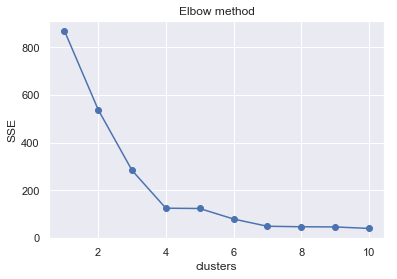

In [76]:
list_n_clusters=[]
list_sse_min=[]
for i in range(1,11):
    list_n_clusters.append(i)
    kmeans = ScratchKMeans(n_clusters=i,n_init=10, max_iter=50, tol=0.001)
    kmeans.fit(X)
    list_sse_min.append(copy.deepcopy(kmeans.sse_min))
    print("クラスター{}個の時のsse最小時のμk:{}".format(i,kmeans.mean_point))
    print("最小SSE:",kmeans.sse_min)

plt.plot(list_n_clusters,list_sse_min, marker="o")
plt.title("Elbow method")
plt.ylabel("SSE")
plt.xlabel("clusters")
plt.show()

In [828]:
# kmeans.predict(X)

## 【問題1】中心点の初期値を決める

In [77]:
#データ点Xn個からランダムにK個(指定したクラスタ数)選ぶ

def mu(self,X): 
    X_for_m = np.zeros((self.n_clusters,X.shape[1])) 
    for i in range(X.shape[1]):
        first_xsamples = np.random.choice(X[:,i],
                                          self.n_clusters,
                                          replace=False) #重複なし
        #各特徴量でサンプル抽出した行列X_for_m
        X_for_m[:,i]=first_xsamples

    #初期値μ１は選んだK個の中心点
    first_m = np.mean(X_for_m,axis=0) #行ごとの平均
    return first_m

# kmeans.first_m(X)

## 【問題2】SSEを求める関数の作成

In [78]:
def sse(self,X):
    '''
    rnk (自分が属するクラスタは1,属さなければ0 )の性質から、
    それぞれ属するクラスタのみ総和を取れば良い
    つまり、(X-self.first_m)の自乗をsumすれば良い
    '''
    #rnkの性質から、それぞれ属するクラスタのみ総和を取れば良い
    sse = []
    for i in range(self.n_clusters):
        sse.append(np.sum(X-self.first_ms(X)[i]**2))
    return sse

## 【問題3】クラスタへの割り当て

In [79]:
#問題３
'''
#中心点 μkを固定 μkはself.mu。
#クラスタへの割り当て
#np.linalg.norm (= √(μk - Xn)(Xn - μk)) 
'''
def clustering(X):
    index_mu_array = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        list_mu = []
        for j in range(self.n_clusters):
            distance = LA.norm(X[0]-self.first_ms(X)[j])
            list_mu.append(distance)
        index_mu = list_mu.index(min(list_mu)) #indexで保持
        print(index_mu)
        #このインデックスを(index_mu_array)状に格納していく
        index_mu_array[i]=index_mu

## 【問題4】中心点の移動

In [ ]:
#問題4
'''
中心点 μkをnp.mean(moved_points_array,axis=0) に更新
'''
def clustering_move_mean(X):
    moved_mean = np.zeros((kmeans.n_clusters,X.shape[1]))
    for i in range(kmeans.n_clusters):
        mean_point = np.mean(X[np.where(index_mu_array.ravel()==i)],
                             axis=0) #index 取得
        moved_mean[i]=mean_point
        
    print(moved_mean)


clustering_move_mean(X)

## 【問題5】繰り返し【問題6】異なる初期値で計算

In [ ]:
#問題６
    list_sse=[]
    for s in range(self.n_init):
        firsts_array = np.zeros_like(self.mean)
        #問題5
        self.mean = self.first_ms(X) #self.mean 初期値設定
        for i in range(self.max_iter):         
            if self.change > self.tol:
                mean_before = copy.deepcopy(self.mean) 
                #deepcopyにしないとself.mean更新前を保持できない。
                mean_after = copy.deepcopy(self.clustering_move_mean(X))
                self.change = LA.norm(mean_after[0] - mean_before[0])
            else:
                break
        #問題5
        self.mean_list = np.block([[[self.mean_list]],[[self.mean]]])
        list_sse.append(self.sse(X)) 
    index_sse_min = list_sse.index(min(list_sse)) #sse最小値のindex
    self.mean_point = self.mean_list[index_sse_min + 1] 
    #self.mean_list[0]がnp.onesのため

    print("sse最少の時のμk",self.mean_point)
    #問題6

## 【問題7】推定

In [ ]:
kmeans.predict(X)

## 【問題8】エルボー法の実装

sse最少の時のμk [[-1.86097353  8.2576415 ]]
クラスター1個の時のsse最小時のμk:[[-1.86097353  8.2576415 ]]
sse最少の時のμk [[-1.7653772   8.17625727]
 [-0.8623605   8.24721209]]
クラスター2個の時のsse最小時のμk:[[-1.7653772   8.17625727]
 [-0.8623605   8.24721209]]
sse最少の時のμk [[-1.7653772   8.17625727]
 [-1.91186205  3.18750686]
 [ 1.61986895  0.60823883]]
クラスター3個の時のsse最小時のμk:[[-1.7653772   8.17625727]
 [-1.91186205  3.18750686]
 [ 1.61986895  0.60823883]]
sse最少の時のμk [[ 1.04829186  5.03092408]
 [-1.95751686  3.87291474]
 [-1.89928142  2.50466299]
 [-1.64996061  7.49068513]]
クラスター4個の時のsse最小時のμk:[[ 1.04829186  5.03092408]
 [-1.95751686  3.87291474]
 [-1.89928142  2.50466299]
 [-1.64996061  7.49068513]]
sse最少の時のμk [[-1.42525273  7.14798437]
 [-1.19075663  3.12161318]
 [ 2.11114739  3.57660449]
 [ 0.96217896  4.51795326]
 [-1.21986433  3.3789856 ]]
クラスター5個の時のsse最小時のμk:[[-1.42525273  7.14798437]
 [-1.19075663  3.12161318]
 [ 2.11114739  3.57660449]
 [ 0.96217896  4.51795326]
 [-1.21986433  3.3789856 ]]
sse最少の時のμk [[-0.92819001 

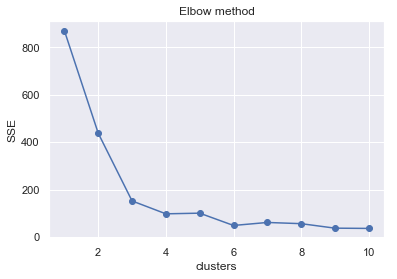

In [81]:
list_n_clusters=[]
list_sse_min=[]
for i in range(1,11):
    list_n_clusters.append(i)
    kmeans = ScratchKMeans(n_clusters=i,n_init=10, max_iter=50, tol=0.01)
    kmeans.fit(X)
    list_sse_min.append(copy.deepcopy(kmeans.sse_min))
    print("クラスター{}個の時のsse最小時のμk:{}".format(i,kmeans.mean_point))

plt.plot(list_n_clusters,list_sse_min, marker="o")
plt.title("Elbow method")
plt.ylabel("SSE")
plt.xlabel("clusters")
plt.show()

## 【問題9】（アドバンス課題）シルエット図

In [835]:
# シルエット図を表示するためのコード


y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

NameError: name 'cluster_labels' is not defined

## クラスタ分析

> - 1) FRESH: annual spending (m.u.) on fresh products (Continuous);
- 2) MILK: annual spending (m.u.) on milk products (Continuous);
- 3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
- 4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
- 5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
- 6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
- 7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
- 8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)

In [83]:
#中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。
data = pd.read_csv('Wholesale customers data.csv')
data.info()
display(data.head(3))
X_df = data.drop(['Channel','Region'],axis=1)
display(X_df.head(3))
X_data = copy.deepcopy(X_df)

scaler = StandardScaler()
scaler.fit(X_data)

X_data_std = pd.DataFrame(scaler.transform(X_data), columns=X_data.columns)
X_data_log = np.log(X_data)
display(X_data_std.head(3))
X_data_array = X_data.values
# print(X_data_array.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844


/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/akishimasaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293


In [84]:
# s = 2
# kmeans_model = KMeans(n_clusters=s, random_state=10).fit(X_data)
# print(kmeans_model.labels_)
# print(kmeans_model.cluster_centers_[:,0], kmeans_model.cluster_centers_[:,1])
# colors = [color_codes[x] for x in kmeans_model.labels_]
# # 第一主成分と第二主成分でプロットする
# plt.figure(figsize=(6, 6))
# for kx, ky, name in zip(x, y, X_data.iloc[:, 0]):
#     plt.text(kx, ky, name, alpha=0.8, size=10)
# plt.scatter(x, y, alpha=0.8,  color=colors) 
# plt.scatter(kmeans_model.cluster_centers_[:,0], kmeans_model.cluster_centers_[:,1], c = "b", marker = "*", s = 50)
# plt.title("Principal Component Analysis")
# plt.xlabel("The first principal component score")
# plt.ylabel("The second principal component score")
# plt.savefig('k-means/keiba_std2_PCA12_plot'+str(s)+'.jpg')
# plt.pause(1)
# plt.close()

### 次元削減

[0.44082893 0.72459292 0.84793705 0.94189209 0.98950481 1.        ]


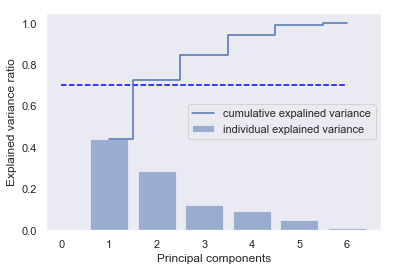

In [85]:
pca = PCA(n_components=None)
pca = pca.fit(X_data_std)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

#### 【問題10】クラスタ数kの選択

In [86]:
# 減衰からクラスタ数4が最適と考える

In [87]:
#対数変換
pca = PCA(n_components = 2)
pca = pca.fit(X_data_log)
data_pca_log = pca.transform(X_data_log)
print(data_pca_log.shape)

kmeans = ScratchKMeans(n_clusters=4,n_init=10, max_iter=50, tol=0.01)
kmeans.fit(data_pca_log)
data_pca_label = kmeans.predict(data_pca_log).ravel()

(440, 2)
sse最少の時のμk [[ 1.30784776 -0.59905912]
 [-2.01636923 -0.42677513]
 [ 0.87599591  3.89488775]
 [-4.60179702  0.33071296]]


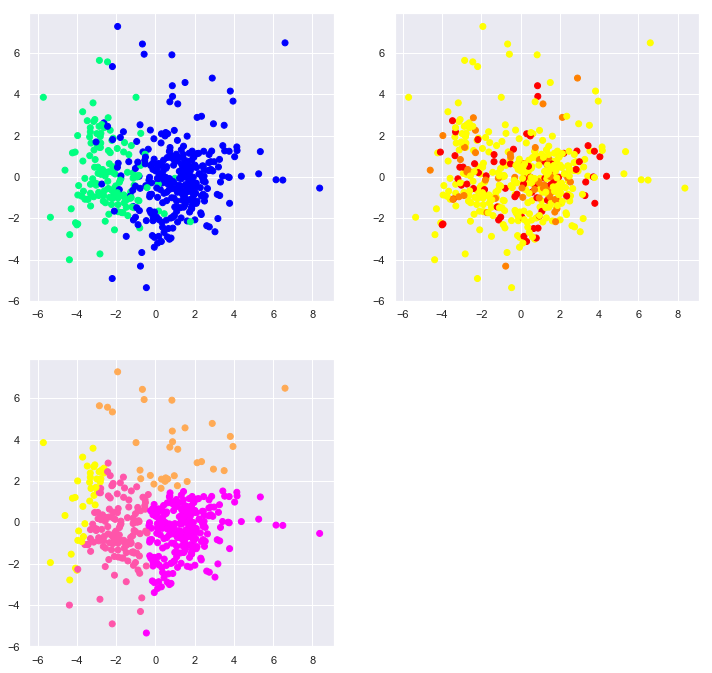

In [89]:
# クラスタ比較 log
plt.figure(figsize=(12,18))
plt.subplot(3,2,1)
plt.scatter(x = data_pca_log[:,0],
            y =data_pca_log[:,1],
            c = data['Channel'], 
            cmap="winter")

plt.subplot(3,2,2)
plt.scatter(x = data_pca_log[:,0],
            y =data_pca_log[:,1],
            c = data['Region'], 
            cmap="autumn")

plt.subplot(3,2,3)
plt.scatter(data_pca_log[:,0],
            data_pca_log[:,1],
            c=data_pca_label,
            cmap='spring')

#### 【問題11】既知のグループとの比較

In [90]:
#元データ
pca = PCA(n_components = 2)
pca = pca.fit(X_data)
data_pca = pca.transform(X_data)
# print(data_pca.shape)
x,y = data_pca[:, 0], data_pca[:, 1]
# print(x,y) 
# X=np.c_[x,y]
kmeans = ScratchKMeans(n_clusters=4,n_init=10, max_iter=50, tol=0.01)
kmeans.fit(data_pca)
data_pca_label = kmeans.predict(data_pca).ravel()

sse最少の時のμk [[25207.37049217 -9377.12120212]
 [-6495.03494222  5317.57356003]
 [ 5243.74639255 -8005.22860094]
 [-4031.70771982 -6050.53592624]]


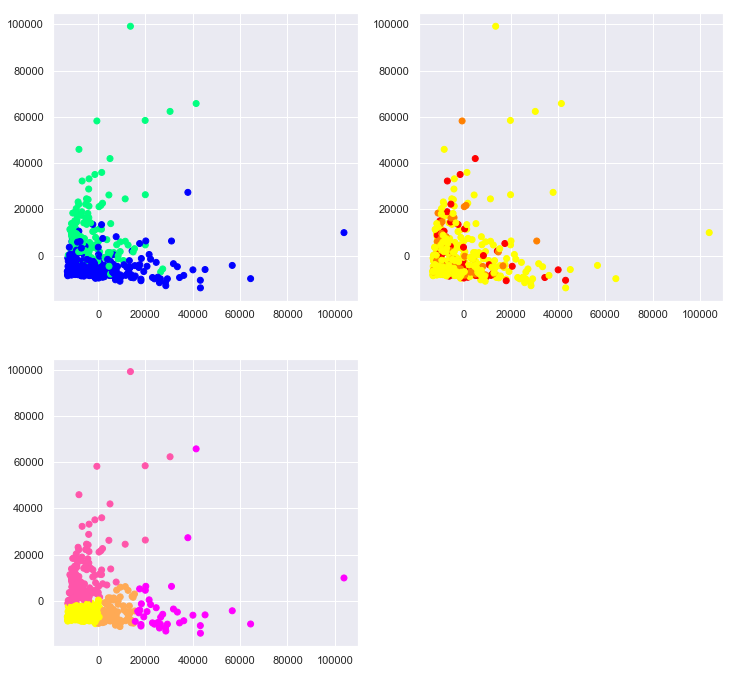

In [91]:
# クラスタ比較
plt.figure(figsize=(12,18))
plt.subplot(3,2,1)
plt.scatter(x = data_pca[:,0],
            y =data_pca[:,1],
            c = data['Channel'], 
            cmap="winter")

plt.subplot(3,2,2)
plt.scatter(x = data_pca[:,0],
            y =data_pca[:,1],
            c = data['Region'], 
            cmap="autumn")

plt.subplot(3,2,3)
plt.scatter(data_pca[:,0],
            data_pca[:,1],
            c=data_pca_label,
            cmap='spring')

### 【問題12】卸売業者にとって有益な情報

In [111]:
display(X_data.describe())
# display(pd.DataFrame(pd.Series(data_pca.ravel()).describe()).transpose())
for i in range(len(np.unique(data_pca_label))):
    print("クラスタ{}".format(i+1))
    display(pd.DataFrame
            (pd.Series
             (data_pca
              [data_pca_label==
               i ].ravel())
             .describe()).transpose())
data_pca_df = pd.DataFrame(data_pca)
print(data_pca_df.shape)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


クラスタ1


,count,mean,std,min,25%,50%,75%,max
0,78.0,13885.693802,22593.209616,-14003.59464,-6000.614891,16982.379235,27073.437577,103863.42532


クラスタ2


,count,mean,std,min,25%,50%,75%,max
0,272.0,3148.504388,13992.004979,-12806.881693,-7238.287175,1241.208483,8157.000748,99226.734125


クラスタ3


,count,mean,std,min,25%,50%,75%,max
0,188.0,736.748349,7343.481057,-11122.328236,-7175.137338,1502.627363,6084.659891,15515.843715


クラスタ4


,count,mean,std,min,25%,50%,75%,max
0,342.0,-6075.982455,3147.661805,-13019.907993,-8245.294751,-6266.777317,-3736.699382,827.633995


(440, 2)


                         0         1
Fresh             0.991805 -0.105480
Milk              0.210913  0.842878
Grocery           0.083182  0.970353
Frozen            0.403144 -0.046514
Detergents_Paper -0.019005  0.924160
Delicassen        0.310205  0.244103


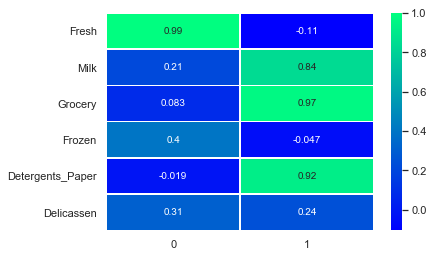

In [113]:
#次元削減後の特徴量と削減前のものの相関を見る
res = (1 - cdist(X_data.T.values, data_pca_df.T.values, metric='correlation'))
res = pd.DataFrame(res, index= X_data.columns, columns = data_pca_df.columns)
print(res)
sns.heatmap(res, vmax=1,linewidths=0.5,annot=True,cmap='winter')

In [99]:
#相関関係行列から、次元削減後の特徴量0は生鮮食品や冷凍食品の売上、
#特徴量１は牛乳、その他持ち帰り惣菜(Grocery)、
#また洗剤や紙類といった雑貨などの売上と関係すると見られる。
'''
以上の特性から、
特徴量0を"stuffs_for_cooking(自炊素材)"、特徴量1を"daily_use(その他食料雑貨)"と名付ける。
'''
dic = {0:'stuffs_for_cooking',1:'daily_use'}
pca_df = data_pca_df.rename(columns=dic)
pca_with_label = copy.deepcopy(pca_df)
#X_data,data_pca_label　ラベル追加
pca_with_label['label']= data_pca_label +1
X_data_with_label = copy.deepcopy(X_data)
X_data_with_label['label'] = data_pca_label +1
# display(pca_df)

<Figure size 864x1296 with 0 Axes>

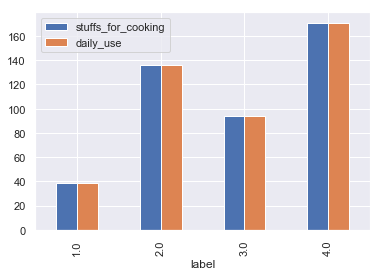

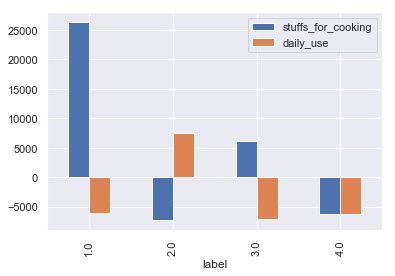

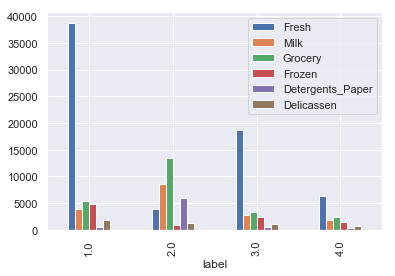

In [100]:
'''
ここからはkmeansで分割した4クラスを
"自炊素材""その他食料雑貨"の2特徴量で比較していく。
#条件ごとにデータを見る際にはPandasのgroupbyが便利です。
'''
#pca_df.groupby(by=label)
#pca_df.groupby('data_pca_label').get_group(0)

# group_1 = pca_with_label.groupby('label').get_group(1)
# group_2 = pca_with_label.groupby('label').get_group(2)
# group_3 = pca_with_label.groupby('label').get_group(3)
# group_4 = pca_with_label.groupby('label').get_group(4)

# display("group_1:",group_1.describe())
# display("group_2:",group_2.describe())
# display("group_3:",group_3.describe())
# display("group_4:",group_4.describe())
plt.figure(figsize=(12,18))
# display("all:",pca_df.describe())
grouped = pca_with_label.groupby('label')
grouped.count().plot.bar()
grouped.median().plot.bar() #外れ値が大きすぎるため、中央値を代表値とする。
grouped_6d = X_data_with_label.groupby('label')
grouped_6d.median().plot.bar()

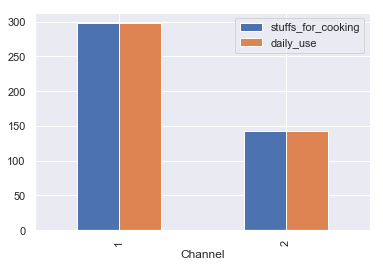

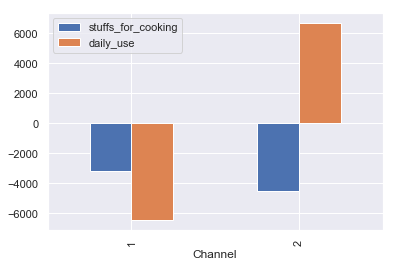

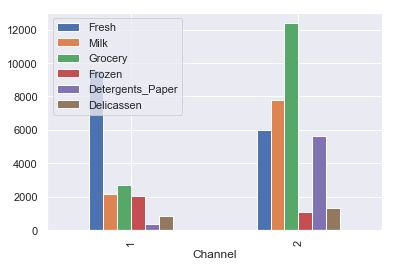

In [101]:
pca_with_Channel = copy.deepcopy(pca_df)
pca_with_Channel['Channel'] = data['Channel']
grouped_Channel = pca_with_Channel.groupby('Channel')
grouped_Channel.count().plot.bar()
grouped_Channel.median().plot.bar()

X_data_with_Channel = copy.deepcopy(X_data)
X_data_with_Channel['Channel'] = data['Channel']
grouped_Channel_6d = X_data_with_Channel.groupby('Channel')
grouped_Channel_6d.median().plot.bar()


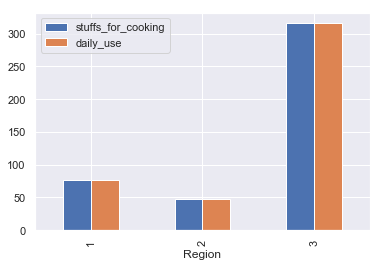

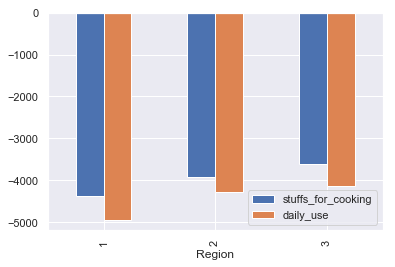

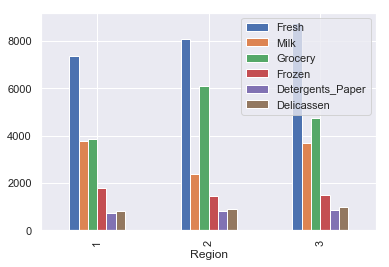

In [102]:
pca_with_Channel = copy.deepcopy(pca_df)
pca_with_Channel['Region'] = data['Region']
grouped_Channel = pca_with_Channel.groupby('Region')
grouped_Channel.count().plot.bar()
grouped_Channel.median().plot.bar()

X_data_with_Channel = copy.deepcopy(X_data)
X_data_with_Channel['Region'] = data['Region']
grouped_Channel_6d = X_data_with_Channel.groupby('Region')
grouped_Channel_6d.median().plot.bar()


In [116]:
grouped.count()

,stuffs_for_cooking,daily_use
label,,
1.0,39,39
2.0,136,136
3.0,94,94
4.0,171,171


In [105]:
'''
以上のグラフから、
売り上げに貢献している少数の顧客の存在(group_2)が示唆された。
彼らは人数的には全体の2.5%しか占めていないが、
6品目ほぼ全てにおいて他のグループよりも合計購入額が大きい。
この"ヘビーユーザー"たちは販売チャネル2に属しているため、
販売チャネル2においては
ヘビーユーザーが購入しがちなdaily_use(その他食料雑貨)ラインナップの充実化と、
ヘビーユーザー向けの優遇措置など顧客の定着化を図ると良い。

一方で自炊特化グループ(group_3)の存在も示唆された。
彼らは販売チャネル1に属しており、自炊関連の"Fresh"売上はヘビーユーザーを上回る。
そのため販売チャネル1ではFresh関連の商品に力を入れるといいと考えられる。
'''

'\n以上のグラフから、\n売り上げに貢献している少数の顧客の存在(group_2)が示唆された。\n彼らは人数的には全体の2.5%しか占めていないが、\n6品目ほぼ全てにおいて他のグループよりも合計購入額が大きい。\nこの"ヘビーユーザー"たちは販売チャネル2に属しているため、\n販売チャネル2においては\nヘビーユーザーが購入しがちなdaily_use(その他食料雑貨)ラインナップの充実化と、\nヘビーユーザー向けの優遇措置など顧客の定着化を図ると良い。\n\n一方で自炊特化グループ(group_3)の存在も示唆された。\n彼らは販売チャネル1に属しており、自炊関連の"Fresh"売上はヘビーユーザーを上回る。\nそのため販売チャネル1ではFresh関連の商品に力を入れるといいと考えられる。\n'